In [1]:
%%capture
%pip install -U 'rockfish[labs]' -f 'https://docs.rockfish.ai/packages/index.html'

In [1]:
import pandas as pd
import random

import rockfish as rf
import rockfish.labs as rl

In [2]:
def generate_timeseries_data(num_rows, rng):
    metadata = rng.choices(["A", "B", "C"], weights=[1, 1, 2], k=num_rows)
    timestamp = pd.date_range(start="1/1/2020", periods=num_rows, freq="D")
    numerical_1 = [rng.uniform(1, 100) for _ in range(num_rows)]
    numerical_2 = [rng.random() * 10 for _ in range(num_rows)]
    categorical_1 = rng.choices([1, 2, 3], weights=[1, 1, 2], k=num_rows)
    categorical_2 = rng.choices(
        ["X", "Y", "Z"], weights=[1, 2, 3], k=num_rows
    )

    data = {
        "metadata_field": metadata,
        "timestamp_field": timestamp,
        "numerical_1": numerical_1,
        "numerical_2": numerical_2,
        "categorical_1": categorical_1,
        "categorical_2": categorical_2,
    }

    return pd.DataFrame(data)


rng = random.Random(42)
ts_data = rf.Dataset.from_pandas(
    "sample1", generate_timeseries_data(100, rng)
)
ts_syn = rf.Dataset.from_pandas("sample2", generate_timeseries_data(100, rng))

### Overall Fidelity Score


In [3]:
# get the default weighted average score on marginal distribution
# other_categorical is the list of categorical fields with numeric values
rl.metrics.marginal_dist_score(
    dataset=ts_data,
    syn=ts_syn,
    metadata=["metadata_field"],
    other_categorical=["categorical_1"],
)

0.8876975945017184

### Mechanisms Across Different Perspectives


#### Session length measurement


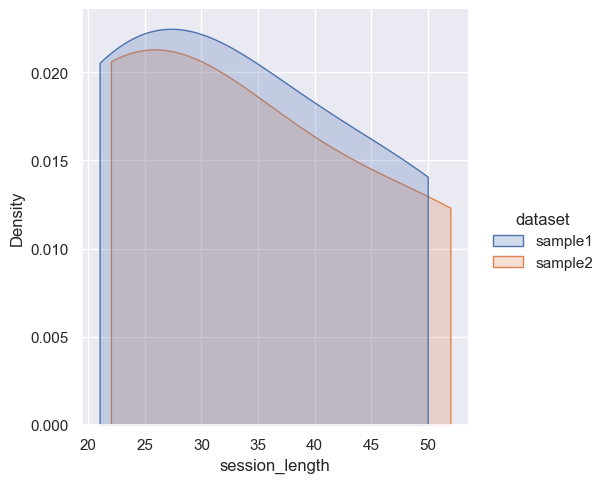

In [4]:
# compute session_length
source_sess = rf.metrics.session_length(ts_data)
syn_sess = rf.metrics.session_length(ts_syn)
# "session_length" is a fixed name from the computed datasets
rl.vis.plot_kde([source_sess, syn_sess], "session_length")

In [5]:
# compute the similarity on the distribution of session length
# KS distance ranges between 0 and 1, the lower the better
rl.metrics.ks_distance(source_sess, syn_sess, "session_length")

0.33333333333333337

#### Interarrival time measurement


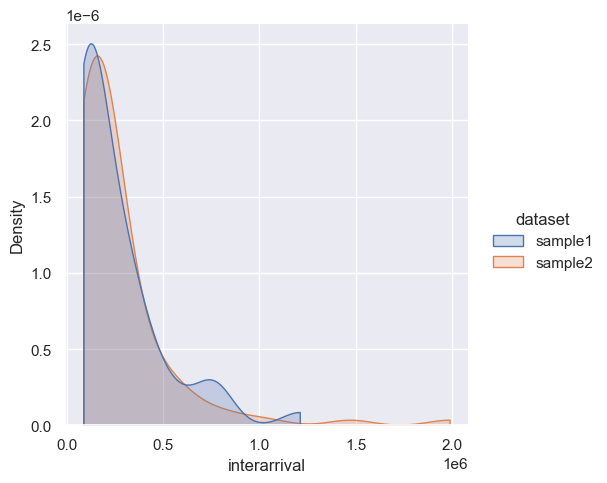

In [6]:
# compute interarrival time
timestamp_field = "timestamp_field"
source_interarrival = rf.metrics.interarrivals(ts_data, timestamp_field)
syn_interarrival = rf.metrics.interarrivals(ts_syn, timestamp_field)
# "interarrival" is a fixed name from the computed datasets
rf.labs.vis.plot_kde(
    [source_interarrival, syn_interarrival], "interarrival", duration_unit="s"
)

In [7]:
# compute the similarity on the distribution of interarrival time
# KS distance ranges between 0 and 1, the lower the better
rl.metrics.ks_distance(source_interarrival, syn_interarrival, "interarrival")

0.09278350515463918

#### Transitions measurement


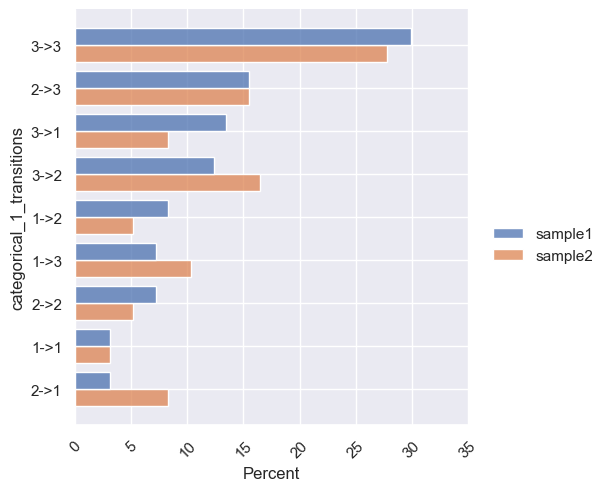

In [8]:
field_name = "categorical_1"
transitions_source = rf.metrics.transitions_within_sessions(
    ts_data, field=field_name
)
transitions_syn = rf.metrics.transitions_within_sessions(
    ts_syn, field=field_name
)
rl.vis.plot_bar(
    [transitions_source, transitions_syn],
    f"{field_name}_transitions",
    orient="horizontal",
)

In [9]:
# compute the similarity on the distribution of categorical field
# TV distance ranges between 0 and 1, the lower the better
rl.metrics.tv_distance(
    transitions_source, transitions_syn, f"{field_name}_transitions"
)

0.12371134020618554

#### Individual field measurement


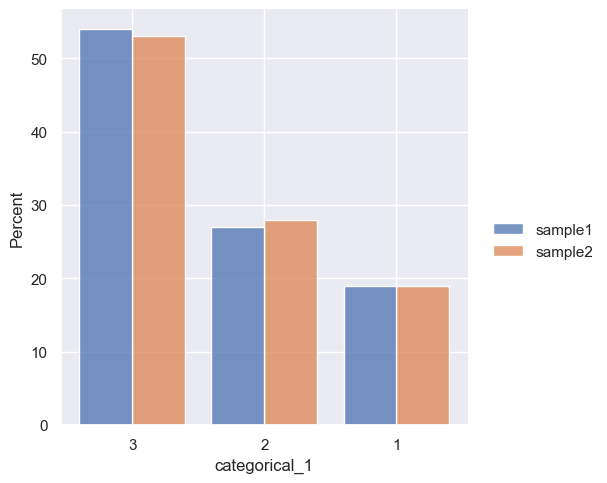

In [10]:
# categorical fields - field 1
rf.labs.vis.plot_bar([ts_data, ts_syn], "categorical_1")

In [11]:
# compute the similarity on the distribution of the categorical field
# TV distance ranges between 0 and 1, the lower the better
rl.metrics.tv_distance(ts_data, ts_syn, "categorical_1")

0.010000000000000009

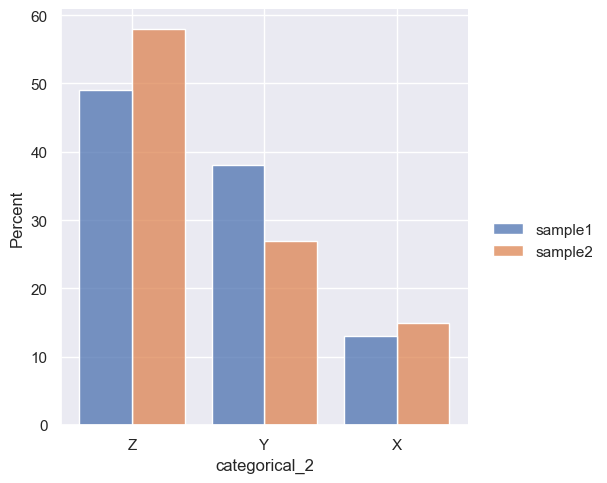

In [12]:
# categorical fields - field 2
rf.labs.vis.plot_bar([ts_data, ts_syn], "categorical_2")

In [13]:
# compute the similarity on the distribution of the categorical field
# TV distance ranges between 0 and 1, the lower the better
rl.metrics.tv_distance(ts_data, ts_syn, "categorical_2")

0.10999999999999997

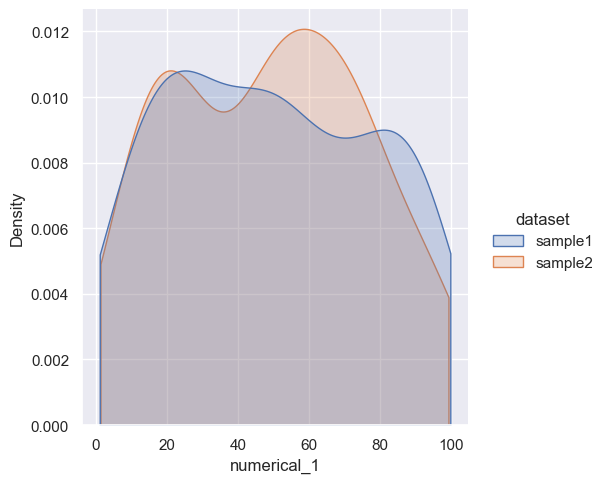

In [14]:
# numerical fields - field 1
rf.labs.vis.plot_kde([ts_data, ts_syn], "numerical_1")

In [15]:
# compute the similarity on the distribution of the numerical field
# KS distance ranges between 0 and 1, the lower the better
rl.metrics.ks_distance(ts_data, ts_syn, "numerical_1")

0.08999999999999997

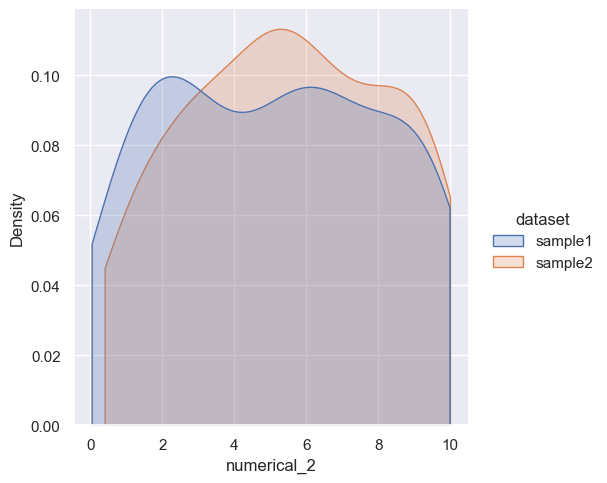

In [16]:
# numerical fields - field 2
rf.labs.vis.plot_kde([ts_data, ts_syn], "numerical_2")

In [17]:
# compute the similarity on the distribution of the numerical field
# KS distance ranges between 0 and 1, the lower the better
rl.metrics.ks_distance(ts_data, ts_syn, "numerical_2")

0.12

#### Correlation measurement


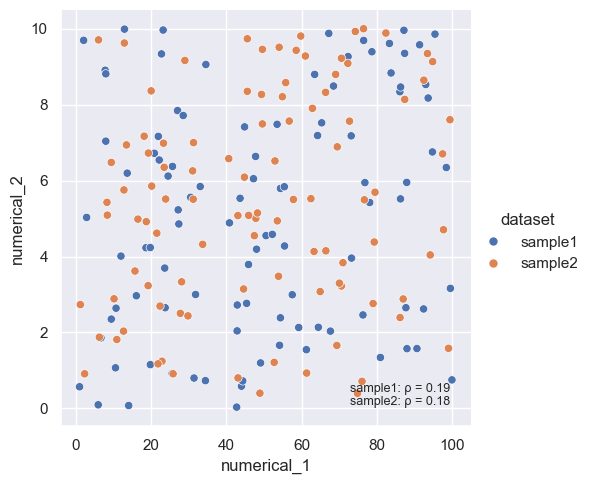

In [18]:
# correlation
rl.vis.plot_correlation([ts_data, ts_syn], "numerical_1", "numerical_2")

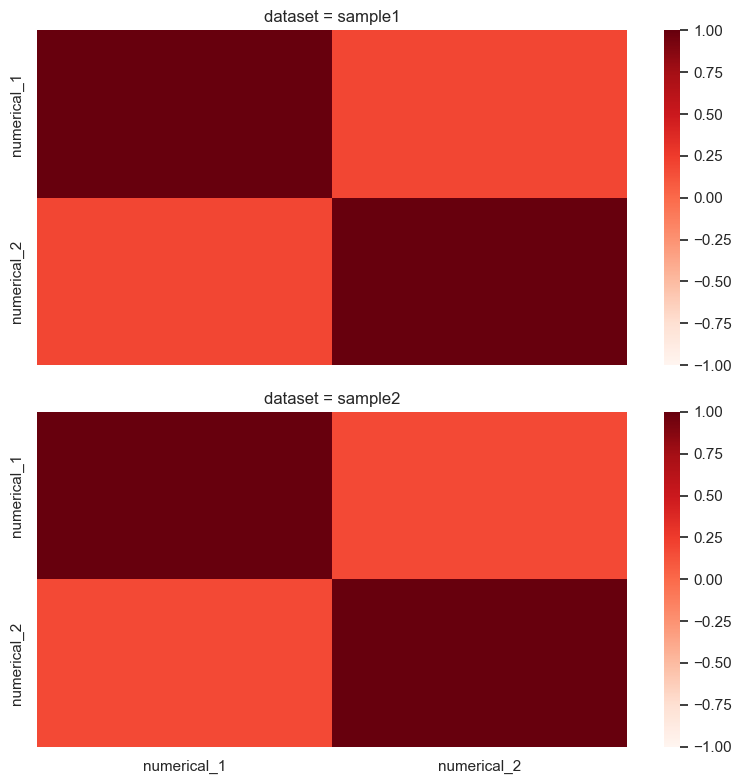

In [19]:
rl.vis.plot_correlation_heatmap(
    [ts_data, ts_syn], ["numerical_1", "numerical_2"]
)

In [20]:
rl.metrics.correlation_score(ts_data, ts_syn, ["numerical_1", "numerical_2"])

0.9902349902452734

#### Association measurement


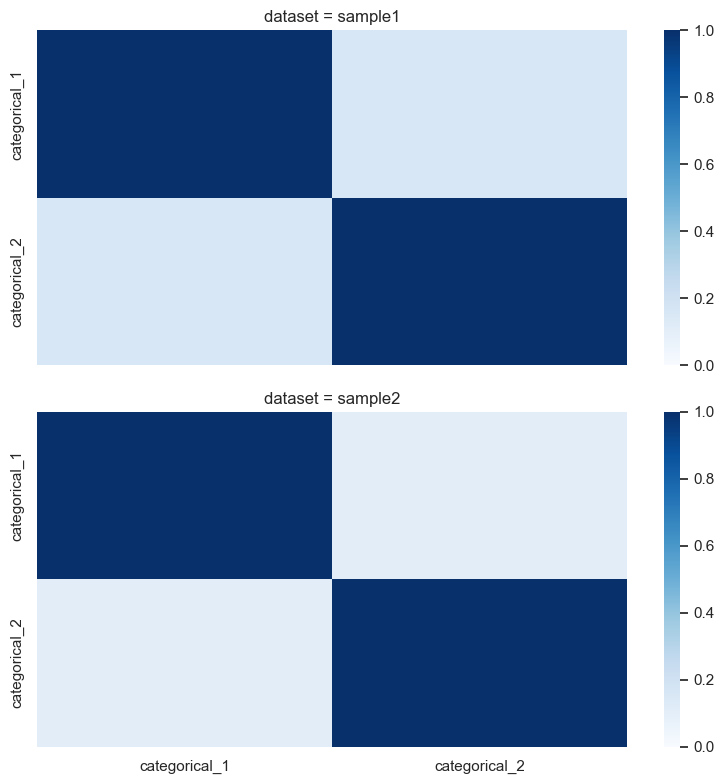

In [21]:
rl.vis.plot_association_heatmap(
    [ts_data, ts_syn], ["categorical_1", "categorical_2"]
)

In [22]:
rl.metrics.association_score(
    ts_data, ts_syn, ["categorical_1", "categorical_2"]
)

0.9487774309361858